In [1]:
import re,os,glob,argparse,datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense,Input,Activation,Flatten,TimeDistributed,MaxPooling1D,AveragePooling1D,Dropout,BatchNormalization
from tensorflow.keras.layers import LSTM,Conv1D,GRU, Bidirectional, Flatten, add, UpSampling1D, Cropping1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from IPython import embed  #变量自动补全
%matplotlib inline

In [2]:
## Params validation_train_data
parser = argparse.ArgumentParser()
parser.add_argument('--model', default='ResNet', type=str, help='choose a type of model')
parser.add_argument('--batch_size', default=100, type=int, help='batch size')
parser.add_argument('--train_data', default='../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_train/x', type=str, help='path of train data')
parser.add_argument('--label_data', default='../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_train/y', type=str, help='path of label data')
parser.add_argument('--epoch', default=50, type=int, help='number of train epoches')
parser.add_argument('--lr', default=1e-3, type=float, help='initial learning rate for Adam')
parser.add_argument('--save_every', default=10, type=int, help='save model at every x epoches')
parser.add_argument('--time_series', default=200, type=int, help='The length of each sample')
parser.add_argument('--rows', default=201, type=int, help='The rows of each sample')
parser.add_argument('--feature', default=1, type=int, help='The feature number of input data ')

parser.add_argument('--model_dir', default=os.path.join('models','ResNet'), type=str, help='directory of the model')
parser.add_argument('--model_name', default='model_050.hdf5', type=str, help='the model name')
args = parser.parse_args(args=[]) #由于在jupyter notebook中，args不为空。
# args = parser.parse_args()      #spyder中语法

#m模型保存路径
save_dir = os.path.join('models',args.model) 
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 1、Load data

In [3]:
def gen_patches(file_name, rows=args.rows, columns=1): 
    # 剖面分块大小和分块步长,对训练数据和标签进行分切割分块
    # rows， columns输入数据的行数和列数
    
    patch_size, stride = args.time_series, 100
    
    # read txt
    f = open(file_name,'r+')
    text = f.read()
    text.replace('\n',';')     #将换行符替换成分隔符
    file_txt = np.mat(text)    #字符串矩阵转换为numpy数字矩阵
    file_txt=file_txt.reshape(rows,columns)
    h, w = file_txt.shape
    #print('w is', h)

    patches = []
    # extract patches
    for i in range(0, h-patch_size+1, stride):
        x = file_txt[i:i+patch_size, :]
        #print("Patch size is ",x.shape)
        patches.append(x)                        
    return patches

In [4]:
def datagenerator(data_dir='train_data/x',rows=args.rows, columns=1, verbose=False):
    # 对所有的训练数据进行切割个重新组合
    file_list = sorted(glob.glob(data_dir+'/*.txt'), key=lambda x:x[-4])  # get name list of all magnetic .txt files

    # initrialize
    data = []
    # generate patches
    for i in range(len(file_list)):
        patch = gen_patches(file_list[i], rows, columns)
        data.append(patch)
        if verbose:
            print(str(i+1)+'/'+ str(len(file_list)) + ' is done ^_^')
    data = np.array(data)   # 图像的话需要, dtype='uint8'
    #print(data)
    #print(data.shape)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2],data.shape[3])) # data.shape[3]为特征维度
    print("Sample's dimension : ",data.shape)
    print('^_^-Training sample data finished-^_^')
    return data

In [6]:
def datagenerator_label(data_dir='train_data/y'):
    file_list = sorted(glob.glob(data_dir+'/*.txt'), key=lambda x:x[-4])  # get name list of all label files
    # initrialize
    data = []
    # generate patches
    for file_name in file_list:
        f = open(file_name,'r+')
        text = f.read()
        text.replace('\n',';')     #将换行符替换成分隔符
        text = np.mat(text)    #字符串矩阵转换为numpy数字矩阵
        data.append(text)
            
    data = np.array(data)   # List to array
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))
    print("Label's dimension : ",data.shape)
    print('^_^-Training Labels data finished-^_^')
    return data

In [8]:
def train_datagen(epoch_num=args.epoch,batch_size=args.batch_size,train_data_dir=args.train_data,label_data_dir=args.label_data,\
                  x_rows=args.rows,x_columns=1):
    while(True):
        n_count = 0
        if n_count == 0:
            #print(n_count)
            # Samples Preprocessing
            xs = datagenerator(train_data_dir, rows=x_rows, columns=x_columns)
            assert len(xs)%args.batch_size ==0, \
            log('make sure the last iteration has a full batchsize, this is important if you use batch normalization!')
            xs = xs.astype('float32')
            # 归一化数据
            scaler_x = MinMaxScaler(feature_range=(0, 1))
            for i_xs in range(xs.shape[0]):
                xs[i_xs] = scaler_x.fit_transform(xs[i_xs])
            
            # Labels 
            ys = datagenerator_label(label_data_dir)
            ys = ys.astype('float32')
            ys1 = ys  # Becasue of classification, delete the second and third column.
            print("Updated Label's dimension :", ys1.shape)
            
            indices = list(range(xs.shape[0]))
            #print('Data length is ',len(indices))
            n_count = 1
        for num in range(epoch_num):
            #print('epoch_num:', num)
            np.random.shuffle(indices)    # shuffle
            for i in range(0, len(indices), batch_size):
                batch_x = xs[indices[i:i+batch_size]]
                batch_y = ys1[indices[i:i+batch_size]]
                """print('\nbatch_x shape : ',batch_x.shape)
                print('batch_y shape : ',batch_y.shape)
                print('\n')"""
                yield batch_x, [batch_y[:,0],batch_y[:,1]]

# 5、Model evaluation and test

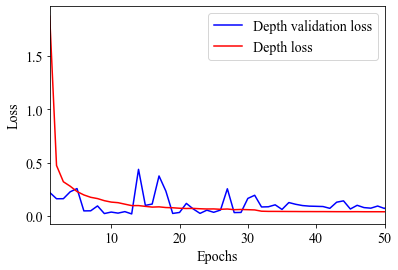

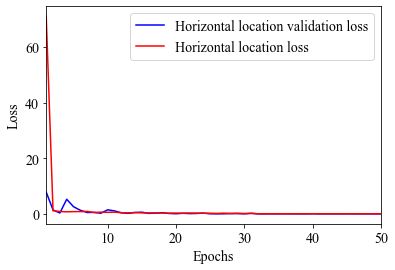

In [10]:
# plot Loss
epochs = np.loadtxt(os.path.join(save_dir,'log.csv'), skiprows=1, delimiter=',', usecols=0) + 1

iden_depth_val_loss = np.loadtxt(os.path.join(save_dir,'log.csv'), skiprows=1, delimiter=',', usecols=7)
iden_depth_loss = np.loadtxt(os.path.join(save_dir,'log.csv'), skiprows=1, delimiter=',', usecols=2)

iden_loc_val_loss = np.loadtxt(os.path.join(save_dir,'log.csv'), skiprows=1, delimiter=',', usecols=9)
iden_loc_loss = np.loadtxt(os.path.join(save_dir,'log.csv'), skiprows=1, delimiter=',', usecols=4)

###############################Identification depth loss and accuracy###################################
plt.rcParams['font.sans-serif'] =  'Times New Roman'
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(6, 4))
plt.plot(epochs,iden_depth_val_loss,'b')
# plt.title('Identification depth training loss')
plt.plot(epochs,iden_depth_loss,'r')
plt.xlim(1,args.epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Depth validation loss','Depth loss'])
plt.savefig('figures/loss_and_accuracy_att1.jpg',format='jpg',dpi=600)
plt.show()

###############################Identification location loss and accuracy###################################
plt.figure(figsize=(6, 4))
plt.plot(epochs,iden_loc_val_loss,'b')
# plt.title('Identification horizontal location training loss')
plt.plot(epochs,iden_loc_loss,'r')
plt.xlim(1,args.epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Horizontal location validation loss','Horizontal location loss'])
plt.savefig('figures/loss_and_accuracy_att2.jpg',format='jpg',dpi=600)
plt.show()

In [11]:
model = load_model(os.path.join(args.model_dir, args.model_name), custom_objects={'SeqSelfAttention': SeqSelfAttention, 
                                        'FeedForward': FeedForward,
                                        'LayerNormalization': LayerNormalization},compile=False)

In [12]:
def testdata_gen(test_data_dir = 'test_data/x',test_label_data_dir = 'test_data/y',rows=args.rows, columns=1):
    # 测试数据集的样本和真实标签的生成
    xs = datagenerator(test_data_dir, rows=args.rows, columns=1)
    xs = xs.astype('float32')
    # 归一化数据
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    for i_xs in range(xs.shape[0]):
        xs[i_xs] = scaler_x.fit_transform(xs[i_xs])
    testX=xs
    
    ys = datagenerator_label(test_label_data_dir)
    ys = ys.astype('float32')
    testY = ys # Becasue of classification, delete the second and third column.
    print("Updated Label's dimension :",testY.shape)
    
    print('testX.shape:',testX.shape)
    print('testY.shape:',testY.shape)
    
    return testX, testY[:,0], testY[:,1]

In [13]:
# evaluate model

# load test sample data
testX, testY0, testY1 = testdata_gen(test_data_dir = '../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_test_5perc/x',test_label_data_dir = '../../MakeDataSet/ModelMagAnomalyData/time_series_dataset/data_test_5perc/y',rows=args.rows, columns=1)

# test model evaluation 
testY0_pred, testY1_pred = model.predict(testX)

print('\nLocation results : ', testY0_pred)
print('\nDepth results : ', testY1_pred)

# calculate error for location regression model
error_location = mean_absolute_error(testY0, testY0_pred)
print('\nTest location MAE error:', error_location)

# calculate error for depth regression model
error_depth = mean_absolute_error(testY1, testY1_pred)  # loss = mean(abs(y_true - y_pred), axis=-1)
print('\nTest depth MAE error:', error_depth)


Sample's dimension :  (20000, 200, 1)
^_^-Training sample data finished-^_^
Label's dimension :  (20000, 2)
^_^-Training Labels data finished-^_^
Updated Label's dimension : (20000, 2)
testX.shape: (20000, 200, 1)
testY.shape: (20000, 2)

Location results :  [[ 77.58255 ]
 [125.459236]
 [ 81.56848 ]
 ...
 [140.96664 ]
 [133.12991 ]
 [135.69716 ]]

Depth results :  [[10.394288 ]
 [ 5.6524673]
 [11.323284 ]
 ...
 [10.886197 ]
 [11.805845 ]
 [13.804329 ]]

Test location MAE error: 0.19478169

Test depth MAE error: 0.17540394


Mean 0.011755212
Standard deviation 0.24982548
Mean 0.02188552
Standard deviation 0.2240624


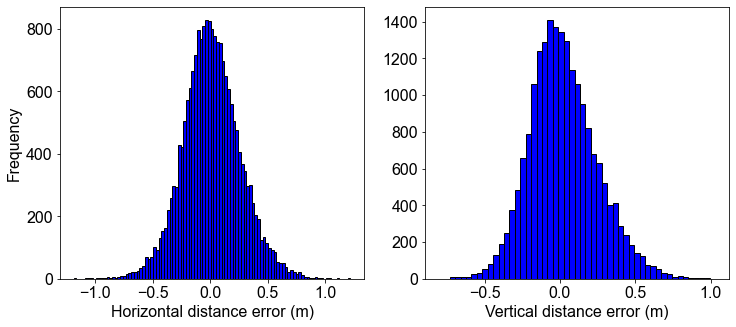

In [14]:
testY_loc_minus = [] #= testY_min_pred - testY_min
testY_depth_minus = [] #testY_max_pred - testY_max  
for i in range(testY0_pred.shape[0]):
    testY_loc_minus.append(testY0_pred[i,0] - testY0[i])
    testY_depth_minus.append(testY1_pred[i,0] - testY1[i])
        
# 绘制柱状分布图
plt.figure(figsize=(12,5))
plt.rcParams['font.sans-serif'] =  'Arial'
plt.rcParams['font.size'] = '16'
plt.subplot(1,2,1)
plt.hist(testY_loc_minus,bins=101,rwidth=1,alpha=1, edgecolor='black', facecolor='blue')
print('Mean', np.mean(testY_loc_minus))
print('Standard deviation', np.std(testY_loc_minus))
# plt.text(-60,2500,'Mean = -2.72',fontdict={'fontsize':14})
# plt.text(-60,2300,'Std = 11.54',fontdict={'fontsize':14})
# plt.text(-8,7500,r'$\mu=-0.03,\ \sigma=0.5$',fontdict={'fontsize':13,'color':'black','weight':'bold','family':'serif'})
# plt.xlim(-1,1)
plt.ylabel('Frequency')
plt.xlabel('Horizontal distance error (m)')

plt.subplot(1,2,2)
plt.hist(testY_depth_minus,bins=51,rwidth=1,alpha=1, edgecolor='black', facecolor='blue')
print('Mean', np.mean(testY_depth_minus))
print('Standard deviation', np.std(testY_depth_minus))
# plt.text(-2,1340,'Mean = 0.82',fontdict={'fontsize':14})
# plt.text(-2,1240,'Std = 0.74',fontdict={'fontsize':14})
# plt.text(-0.9,1650,r'$\mu=0.09,\ \sigma=0.2$',fontdict={'fontsize':13,'color':'black','weight':'bold','family':'serif'})
# plt.xlim(-1.5,1.5)
# plt.ylabel('Frequency')
plt.xlabel('Vertical distance error (m)')
plt.savefig('./figures/histgram_position_5perc.jpg',format='jpg',dpi=600)
plt.savefig('./figures/histgram_position_5perc.svg',format='svg',dpi=1000)
plt.show()

## Comparison with ResNet Results

### ResNet模型导入

In [16]:
model_path_filename_ResNet = 'models/ResNet/model_050.hdf5'
model_res = load_model(model_path_filename_ResNet)

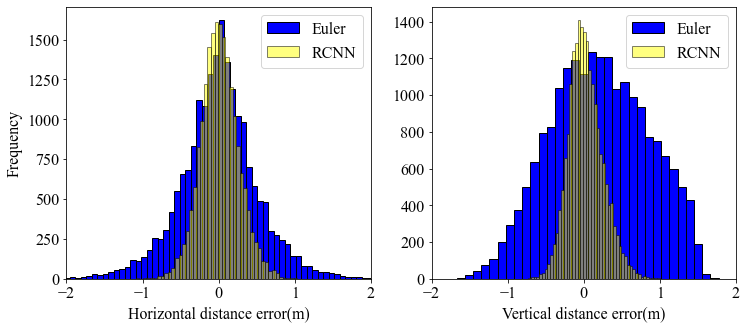

In [17]:
testY_loc_minus_euler = np.loadtxt('../../EulerMagInversion/EulerProcessingTheoryData/hists_data/noise5perc9win.txt', skiprows=0, delimiter=' ', usecols=0)
testY_depth_minus_euler = np.loadtxt('../../EulerMagInversion/EulerProcessingTheoryData/hists_data/noise5perc9win.txt', skiprows=0, delimiter=' ', usecols=1)
        
# 绘制柱状分布图
plt.figure(figsize=(12,5))
plt.rcParams['font.sans-serif'] =  'Times New Roman'
plt.rcParams['font.size'] = '16'
plt.subplot(1,2,1)
plt.hist(testY_loc_minus_euler,bins=81,rwidth=1,alpha=1, edgecolor='black', facecolor='blue',label='Euler')
plt.hist(testY_loc_minus,bins=51,rwidth=1,alpha=0.5, edgecolor='black', facecolor='yellow',label='RCNN')
plt.legend()
# print('Mean', np.mean(testY_loc_minus_euler))
# print('Standard deviation', np.std(testY_loc_minus_euler))
plt.xlim(-2,2)
plt.ylabel('Frequency')
plt.xlabel('Horizontal distance error(m)')

plt.subplot(1,2,2)
plt.hist(testY_depth_minus_euler,bins=61,rwidth=1,alpha=1, edgecolor='black', facecolor='blue',label='Euler')
plt.hist(testY_depth_minus,bins=51,rwidth=1,alpha=0.5, edgecolor='black', facecolor='yellow',label='RCNN')
plt.legend()
# print('Mean', np.mean(testY_depth_minus_euler))
# print('Standard deviation', np.std(testY_depth_minus_euler))
plt.xlim(-2,2)
# plt.ylabel('Frequency')
plt.xlabel('Vertical distance error(m)')
plt.savefig('./figures/histgram_position_5noise_comparison.jpg',format='jpg',dpi=600)
plt.savefig('./figures/histgram_position_5noise_comparison.svg',format='svg',dpi=1000)
plt.show()